# Homework3 - Applied Machine Learning
#### Group member: Shengzhao LEI - Tao SUN - Xiangzhe MENG

In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_context('notebook')
sns.set()
pd.options.mode.chained_assignment = None

## Question 1: Propensity score matching

#### Import data

In [5]:
df_lalonde = pd.read_csv('data/lalonde.csv')
df_lalonde.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1. A naive analysis

Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers.

#### Description of the outcome variable of the two groups

In [6]:
df_treat = df_lalonde[df_lalonde["treat"] == 1]
df_treat_re78 = df_treat.filter(items=['re78'])
treat_describe = df_treat_re78.describe()

In [7]:
df_non_treat = df_lalonde[df_lalonde["treat"] == 0]
df_non_treat_re78 = df_non_treat.filter(items = ['re78'])
control_describe = df_non_treat_re78.describe()

In [8]:
df_describe = pd.concat([treat_describe,control_describe],axis=1)
df_describe.columns = ['treated group','control group']
df_describe

,treated group,control group
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000


According to the description dataframe, there are many more people in the control group than in the treated group. We find that the mean is greater than the median in both groups and both the mean and the median are greater in the control group. Besides, we observe that the lower and upper quartiles are closer to the median in the treated group. The highest income in the treated group is 3 times higher than that in the control group.

#### Outcome distribution plots

In order to show the outcome distribution in a more clear way, we choose to use **distribution plot, box plot and violin plot** in this part.

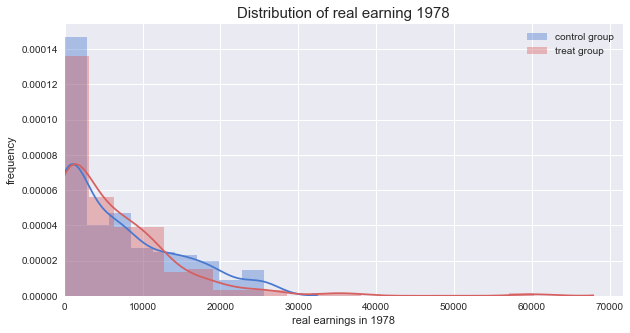

In [9]:
f, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)
sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(df_non_treat_re78, color="b",ax=axes,label='control group')
sns.distplot(df_treat_re78, color="r",ax=axes,label='treat group')
axes.set_title('Distribution of real earning 1978',fontsize = 15)
axes.set_xlabel('real earnings in 1978')
axes.set_ylabel('frequency')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.legend()
plt.show()

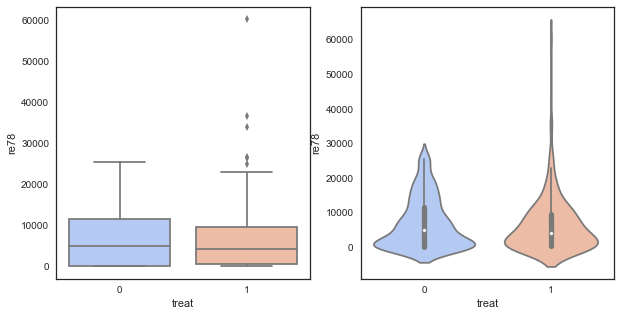

In [10]:
f, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True)
sns.set(style="ticks")
sns.boxplot(x="treat", y="re78", data=df_lalonde, palette="coolwarm",ax=axes[0])
sns.violinplot(x="treat", y="re78", data=df_lalonde, palette="coolwarm", ax=axes[1])
plt.show()

- The distribution plot presents a similar outcome distribution of the two groups.
- The box plot shows that there are more large outliers in treat group than in the control group while most of the real incomes of the treated groups tend to lie closer to the median. 
- The violin plot also shows the probability density of the data at each possible values are not very different between the two groups.

#### Naive conclusion

As a naive "researcher", we can easily conclude that the outcome distribution of the two groups are roughly similar, which indicates that the training program is not very helpful, even on the contrary it tends to make one person perform worse.

### 2. A closer look at the data

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.

#### 2.1 - Description of all the features of the two groups

In this part, we are going to give a general description of **age, years of education, real earnings in 1974 & in 1975** values.

In [11]:
treat_describe = df_treat.filter(items=['age','educ','re74','re75']).describe()
no_treat_describe = df_non_treat.filter(items=['age','educ','re74','re75']).describe()
df_describe = pd.concat([treat_describe,no_treat_describe],axis = 1)
df_describe.columns = [['treat group','treat group','treat group','treat group','control group','control group','control group','control group'],
                       ['age','educ','re74','re75','age','educ','re74','re75']]
df_describe

treat group                                         control group  \
              age        educ          re74          re75           age   
count  185.000000  185.000000    185.000000    185.000000    429.000000   
mean    25.816216   10.345946   2095.573689   1532.055314     28.030303   
std      7.155019    2.010650   4886.620353   3219.250870     10.786653   
min     17.000000    4.000000      0.000000      0.000000     16.000000   
25%     20.000000    9.000000      0.000000      0.000000     19.000000   
50%     25.000000   11.000000      0.000000      0.000000     25.000000   
75%     29.000000   12.000000   1291.468000   1817.284000     35.000000   
max     48.000000   16.000000  35040.070000  25142.240000     55.000000   

                                               
             educ          re74          re75  
count  429.000000    429.000000    429.000000  
mean    10.235431   5619.236506   2466.484443  
std      2.855238   6788.750796   3291.996183  
min      0.000000      0.000000      0.000000  
25%      9.000000      0.000000      0.000000  
50%     11.000000   2547.047000   1086.726000  
75%     12.000000   9277.128000   3881.419000  
max     18.000000  25862.320000  18347.230000

#### 2.2 - Feature distribution plots

In this part, we are going to use different kinds of plots: **histogram, distribution plot, pie chart, box plot & violin plot** to compare all the features' distribution.

#### 2.2.0 - Useful functions to generate plots

In [12]:
def histogram(x_value, hue_value, data_value, title):
    f, axes = plt.subplots(1, 1, figsize = (20,5), sharex = True, sharey = True)
    flatui = ["#3498db","#e74c3c"]
    sns.set_palette(flatui)
    ax = sns.countplot(x = x_value, hue = hue_value, data = data_value)
    ax.set_title(title,fontsize = 20)
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize = 15)
    j = ax.get_ylabel()
    ax.set_ylabel(j, fontsize = 15)

In [13]:
def box_violin_plot(x_value, y_value, data_value):
    f, axes = plt.subplots(1, 2, figsize = (10,5), sharex = True)
    sns.set(style = "ticks")
    sns.boxplot(x = x_value, y = y_value, data = data_value, palette = "coolwarm",ax = axes[0])
    sns.violinplot(x = x_value, y = y_value, data = data_value, palette = "coolwarm", ax = axes[1])

In [14]:
def pie_plot(treat, control, title):
    temp_df = pd.DataFrame({'treat group': treat, 'control group': control})
    temp_df.plot.pie(subplots = True, legend = False, title = title, figsize = (10,5))

In [15]:
def distribution_plot(treat_group_value, control_group_value, title):
    f, axes = plt.subplots(1, 1, figsize = (15,6), sharex = True, sharey = True)
    sns.set(style = "white", palette = "muted", color_codes = True)
    axes.set_title(title, fontsize=15)
    sns.distplot(treat_group_value, color = "r", ax = axes, label = 'treat group')
    sns.distplot(control_group_value, color = "b", ax = axes, label = 'control group')
    plt.xlim(xmin=0)
    plt.autoscale(axis='y',enable=True)
    plt.legend()
    plt.show()

#### 2.2.1 - Distribution of age

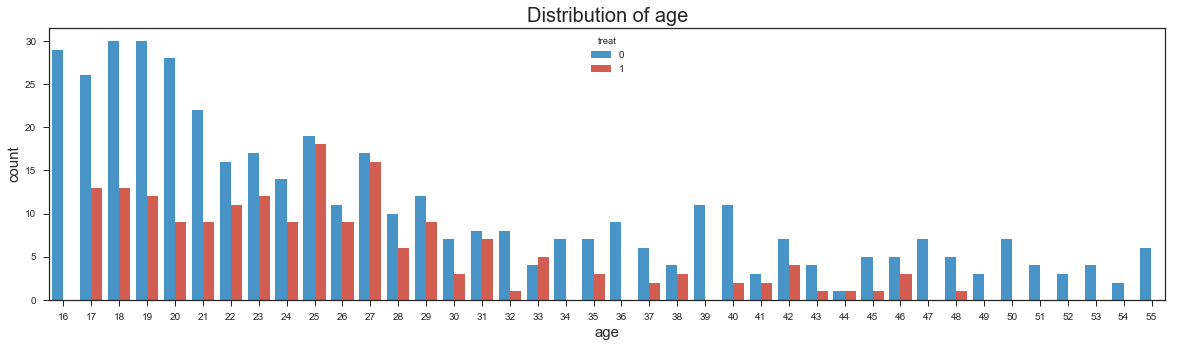

In [16]:
x_value = 'age'
hue_value = 'treat'
data_value = df_lalonde
title = 'Distribution of age'
histogram(x_value, hue_value, data_value, title)

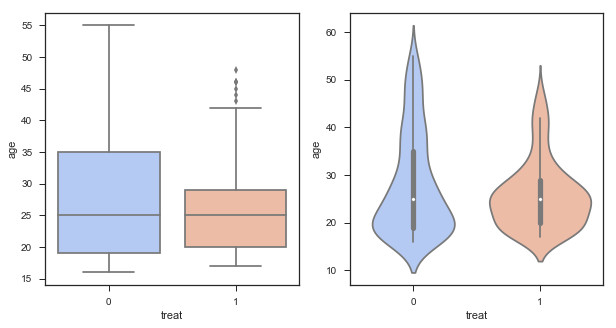

In [17]:
x_value = 'treat'
y_value = 'age'
data_value = df_lalonde
box_violin_plot(x_value, y_value, data_value)

#### 2.2.2 - Distribution of years of eductation

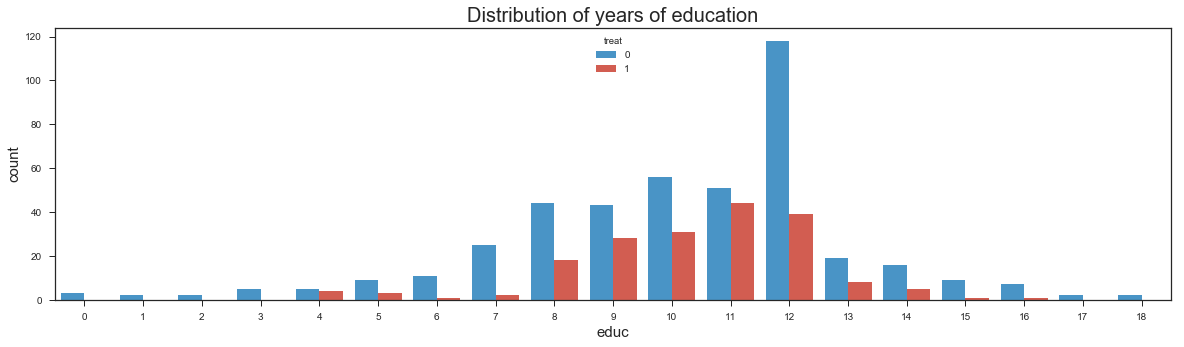

In [18]:
x_value = 'educ'
hue_value = 'treat'
data_value = df_lalonde
title = 'Distribution of years of education'
histogram(x_value, hue_value, data_value, title)

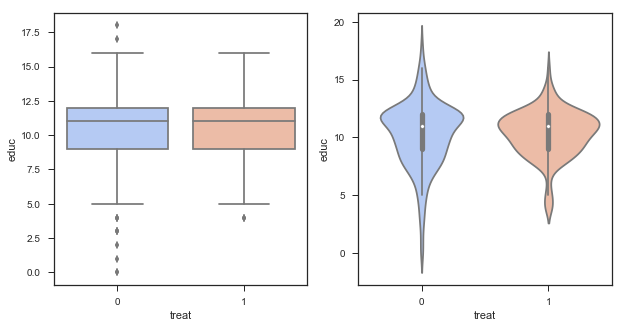

In [19]:
x_value = 'treat'
y_value = 'educ'
data_value = df_lalonde
box_violin_plot(x_value, y_value, data_value)

#### 2.2.3 - Distribution of race

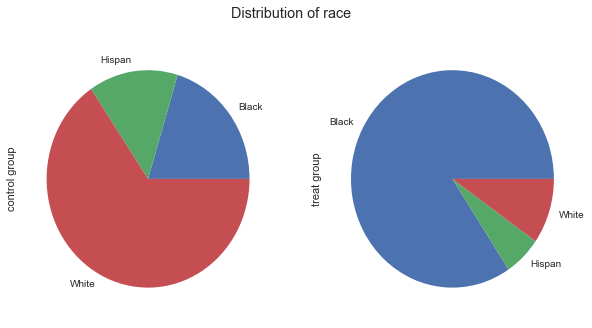

In [20]:
treat_race = (df_treat.hispan + 2 * df_treat.black).replace({0: 'White', 1: 'Hispan', 2: 'Black'}).value_counts()
control_race = (df_non_treat.hispan + 2 * df_non_treat.black).replace({0: 'White', 1: 'Hispan', 2: 'Black'}).value_counts()
pie_plot(treat_race, control_race, 'Distribution of race')

#### 2.2.4 -  Distributions of marital status

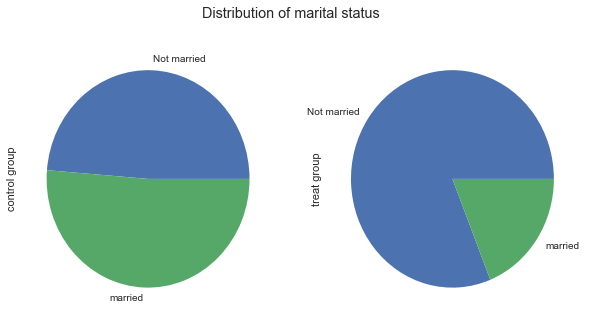

In [21]:
treat_marriage = df_treat['married'].replace({0: 'Not married', 1: 'married'}).value_counts()
control_marriage = df_non_treat['married'].replace({0: 'Not married', 1: 'married'}).value_counts()
pie_plot(treat_marriage, control_marriage, 'Distribution of marital status')

#### 2.2.5 - Distributions of higher education status

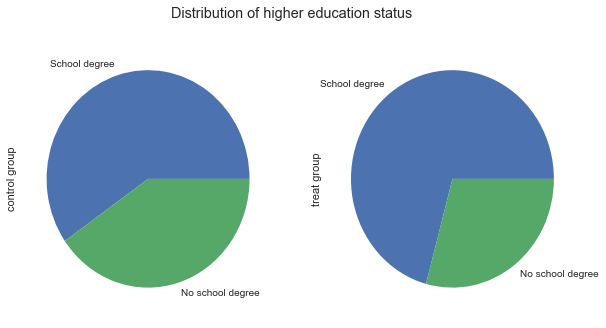

In [22]:
treat_educ = df_treat['nodegree'].replace({0: 'No school degree', 1: 'School degree'}).value_counts()
control_educ = df_non_treat['nodegree'].replace({0: 'No school degree', 1: 'School degree'}).value_counts()
pie_plot(treat_educ, control_educ, 'Distribution of higher education status')

#### 2.2.6 - Distributions of real earnings in 1974

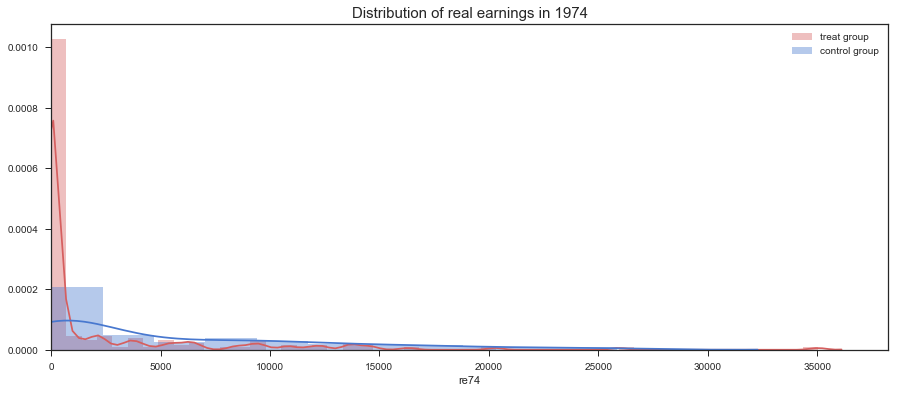

In [23]:
treat_group_value = df_treat['re74']
control_group_value = df_non_treat['re74']
title = 'Distribution of real earnings in 1974'
distribution_plot(treat_group_value, control_group_value, title)

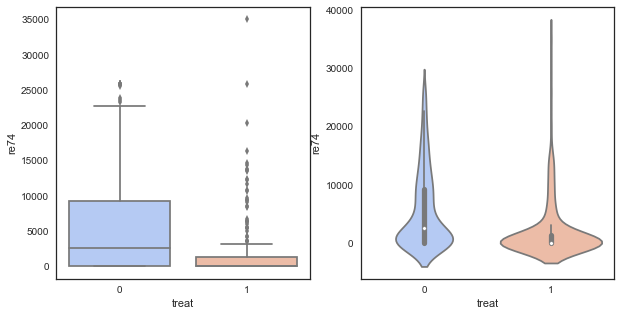

In [24]:
x_value = 'treat'
y_value = 're74'
data_value = df_lalonde
box_violin_plot(x_value, y_value, data_value)

#### 2.2.7 - Distributions of real earnings in 1975

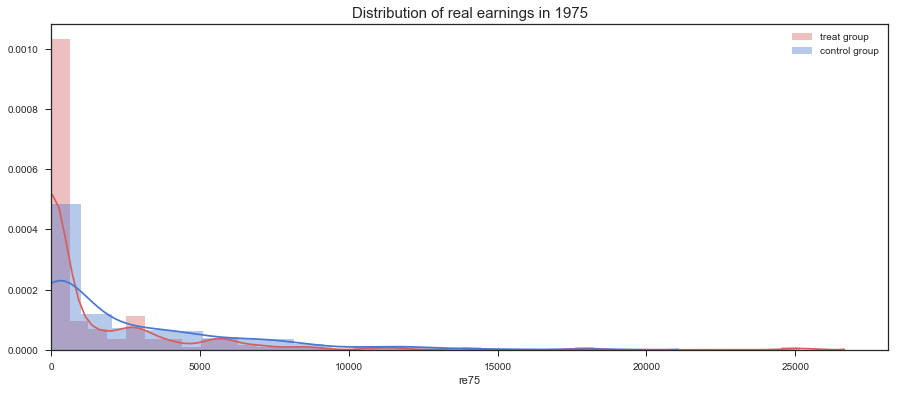

In [25]:
treat_group_value = df_treat['re75']
control_group_value = df_non_treat['re75']
title = 'Distribution of real earnings in 1975'
distribution_plot(treat_group_value, control_group_value, title)

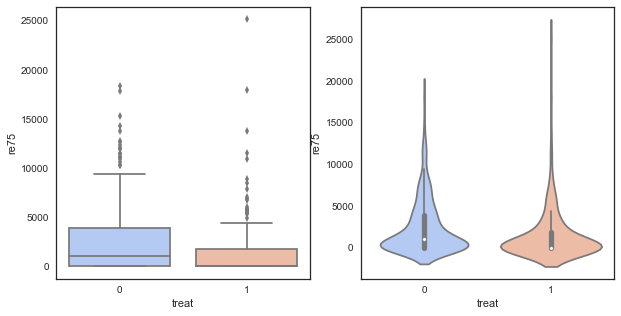

In [26]:
x_value = 'treat'
y_value = 're75'
data_value = df_lalonde
box_violin_plot(x_value, y_value, data_value)

According to the plots above, we find that all the distributions of feature are more or less differnet between treated and control groups. As we know, all features need to have the same distriution in both groups so that the experiment can be meaningful and the comparison is reasonbale. Thus, The difference between the distribution of the features makes the observation of the task 1 be meaningless and imprecise. Hence, we are supposed to balance the dataset in order to draw a persuasive conclusion.

### 3. A propensity score model

Using logistic regression to estimate propensity scores for all points in the dataset, firstly, we train the logistic regression modle with data X and label y.

In [27]:
from sklearn import linear_model,calibration
logistic = linear_model.LogisticRegression()
X = df_lalonde.drop(['id','treat','re78'],axis=1).as_matrix()
y = df_lalonde['treat'].values
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
propensity = pd.DataFrame(logistic.predict_proba(X))
propensity.head()

,0,1
0,0.556650,0.443350
1,0.855340,0.144660
2,0.277645,0.722355
3,0.335849,0.664151
4,0.301714,0.698286


Using the trained model to predict the propensity score of each data point.

In [29]:
df_lalonde['propensity score'] = propensity[1].values
df_lalonde.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


### 4. Balancing the dataset via matching

In order to balance the dataset, we use the python library **networkx** to help match subjects.

First of all, we create a graph with all the IDs as the name of nodes.

In [30]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(df_lalonde['id'].values)

Then, we add edges to generate a **complete bipartite graph** between treated and control groups. For each edge, we define **the negative value of the difference  between the propensity score of the two nodes as weight** because we are going to match the data with the help of funtion **max_weight_matching**.

- **networkx.max_weight_matching**: a matching is a subset of edges in which no node occurs more than once and the cardinality of a matching is the number of matched edges, the weight of a matching is the sum of the weights of its edges.

Our real purpose is to minimize the sum of absolute propensity-score differences between the two matched subjects, which is equivalent to maximize the sum of negative values of differences.

In [31]:
for i in df_lalonde[df_lalonde['treat'] == 1]['id'].values:
    for j in df_lalonde[df_lalonde['treat'] == 0]['id'].values:
        w = -abs(df_lalonde[df_lalonde['id'] == i]['propensity score'].values[0] - df_lalonde[df_lalonde['id'] == j]['propensity score'].values[0])
        G.add_edge(i, j, weight=w)          

In [32]:
dict_node = nx.max_weight_matching(G,maxcardinality=True)

After matching, we collect all the matching subjects to a new dataframe and divide them into two groups: treated and control.

In [33]:
df_matching = df_lalonde[df_lalonde['id'].isin(dict_node.keys())]
df_treat_matching = df_matching[df_matching["treat"] == 1]
df_non_treat_matching = df_matching[df_matching["treat"] == 0]

#### 4.1 - Compare the outcomes (re78) between the two groups (treated and control).

In [34]:
treat_describe = df_treat_matching['re78'].describe()
control_describe = df_non_treat_matching['re78'].describe()
df_describe = pd.concat([treat_describe, control_describe],axis = 1)
df_describe.columns = ['treated group','control group']
df_describe

,treated group,control group
count,185.000000,185.000000
mean,6349.143530,5312.474907
std,7867.402218,5842.884861
min,0.000000,0.000000
25%,485.229800,0.000000
50%,4232.309000,3392.860000
75%,9642.999000,7933.914000
max,60307.930000,20243.380000


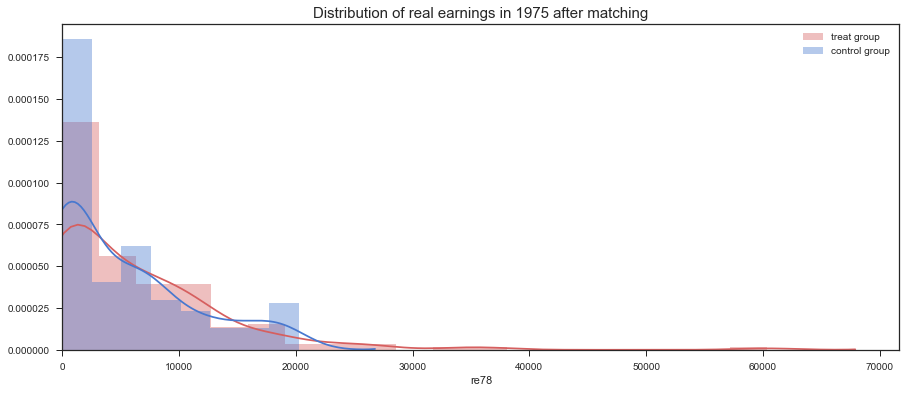

In [35]:
treat_group_value = df_treat_matching['re78']
control_group_value = df_non_treat_matching['re78']
title = 'Distribution of real earnings in 1975 after matching'
distribution_plot(treat_group_value, control_group_value, title)

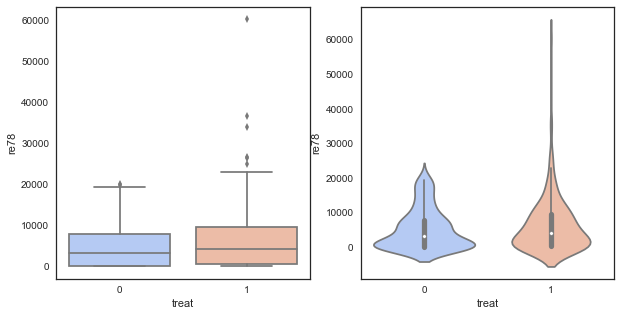

In [36]:
x_value = 'treat'
y_value = 're78'
data_value = df_matching
box_violin_plot(x_value, y_value, data_value)

From the plots above, we find that the difference between incomes after the training program of the two groups is more evident. The mean, median and higher quartile values of the treated group are all larger than those of the control group. Nevertheless, we still can't draw a reasonable conclusion concerning the effectiveness of the training program because we haven't check the distribution of all the features. If and only if when the distribution of all the relative features for the two groups are similar can we start to analyze the outcome result. 

Now, we are going to have a look at the feature distributions.

The distributions of all features for the two groups are shown as below:

####  4.2.1 - Distributions of age

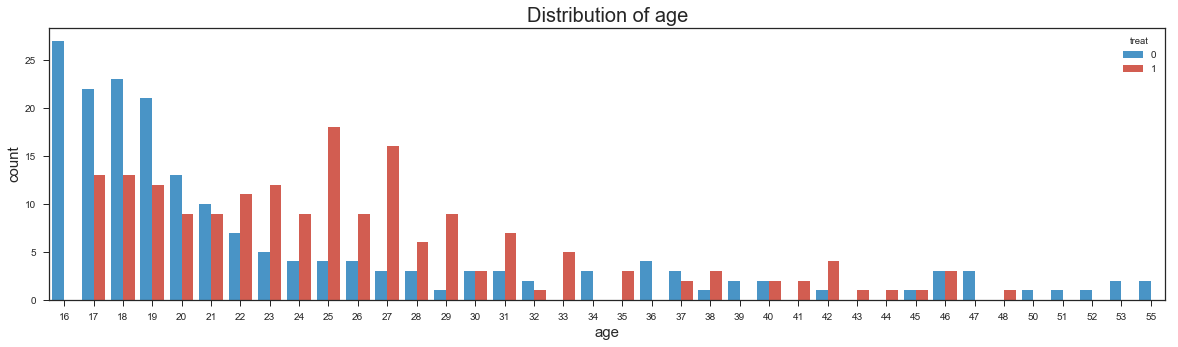

In [37]:
x_value = 'age'
hue_value = 'treat'
data_value = df_matching
title = 'Distribution of age'
histogram(x_value, hue_value, data_value, title)

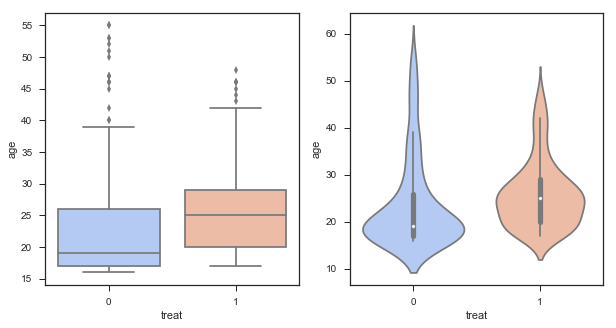

In [38]:
x_value = 'treat'
y_value = 'age'
data_value = df_matching
box_violin_plot(x_value, y_value, data_value)

#### 4.2.2 - Distributions of years of education

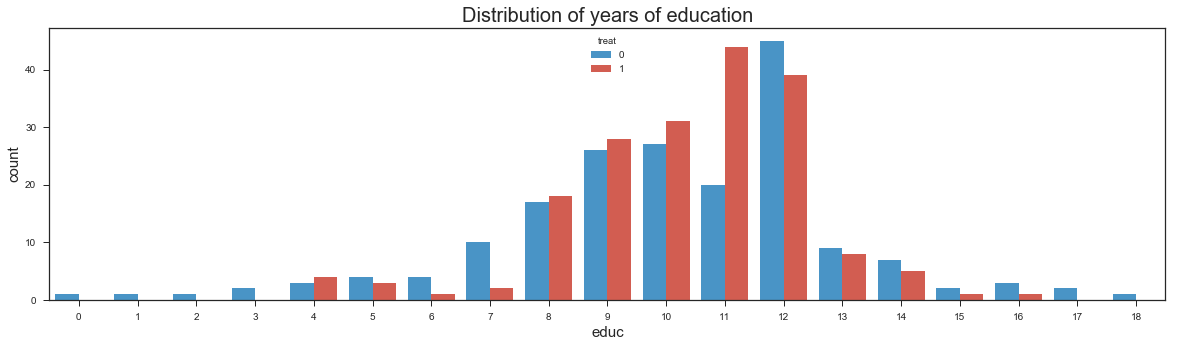

In [39]:
x_value = 'educ'
hue_value = 'treat'
data_value = df_matching
title = 'Distribution of years of education'
histogram(x_value, hue_value, data_value, title)

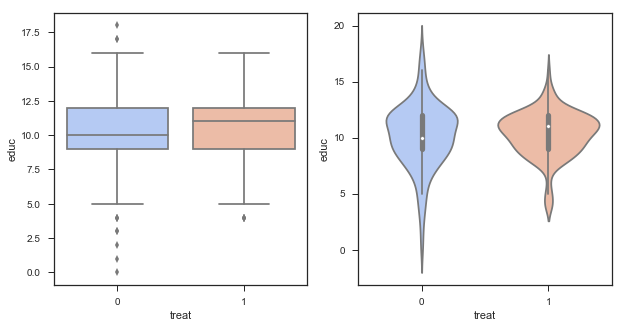

In [40]:
x_value = 'treat'
y_value = 'educ'
data_value = df_matching
box_violin_plot(x_value, y_value, data_value)

We are delight to find that the distributions of "years of education" are similiar after matching.

#### 4.2.3 - Distributions of race

In [41]:
df_treat = df_matching[df_matching['treat'] == 1]
df_non_treat = df_matching[df_matching['treat'] == 0]

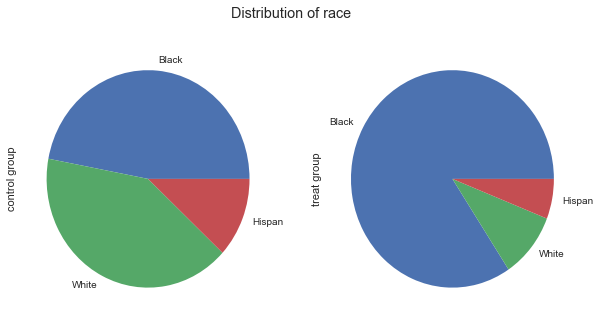

In [42]:
treat_race = (df_treat.hispan + 2 * df_treat.black).replace({0: 'White', 1: 'Hispan', 2: 'Black'}).value_counts()
control_race = (df_non_treat.hispan + 2 * df_non_treat.black).replace({0: 'White', 1: 'Hispan', 2: 'Black'}).value_counts()
pie_plot(treat_race, control_race, 'Distribution of race')

#### 4.2.4 - Distributions of marital status

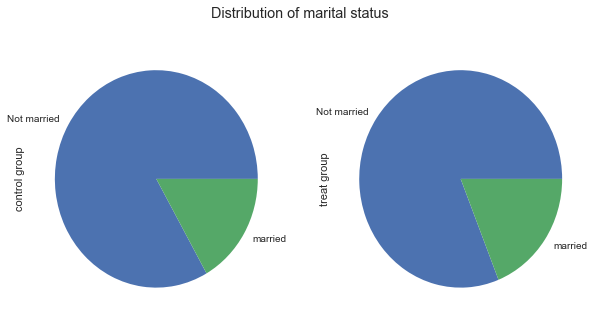

In [43]:
treat_marriage = df_treat['married'].replace({0: 'Not married', 1: 'married'}).value_counts()
control_marriage = df_non_treat['married'].replace({0: 'Not married', 1: 'married'}).value_counts()
pie_plot(treat_marriage, control_marriage, 'Distribution of marital status')

#### 4.2.5 - Distributions of higher education status

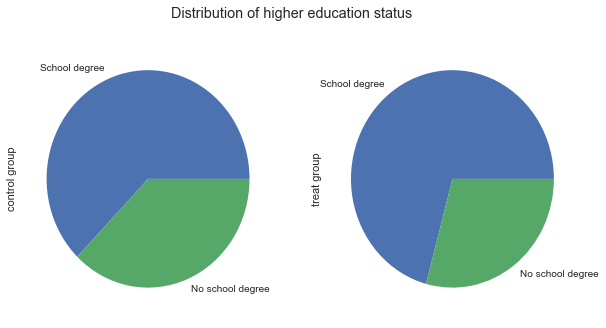

In [44]:
treat_educ = df_treat['nodegree'].replace({0: 'No school degree', 1: 'School degree'}).value_counts()
control_educ = df_non_treat['nodegree'].replace({0: 'No school degree', 1: 'School degree'}).value_counts()
pie_plot(treat_educ, control_educ, 'Distribution of higher education status')

#### 4.2.6 - Distributions of real earnings in 1974

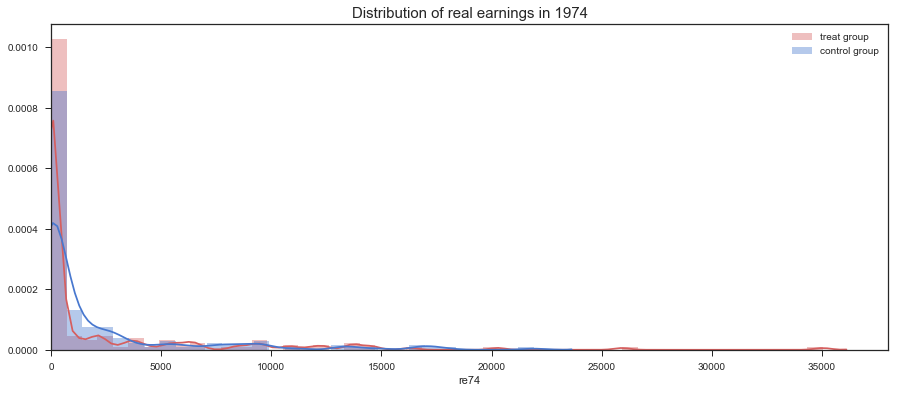

In [45]:
treat_group_value = df_treat['re74']
control_group_value = df_non_treat['re74']
title = 'Distribution of real earnings in 1974'
distribution_plot(treat_group_value, control_group_value, title)

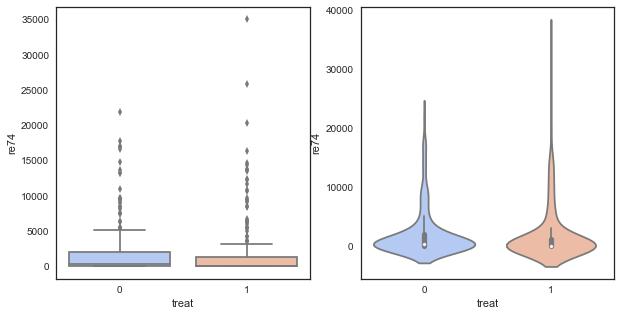

In [46]:
x_value = 'treat'
y_value = 're74'
data_value = df_matching
box_violin_plot(x_value, y_value, data_value)

#### 4.2.7 - Distributions of real earnings in 1975

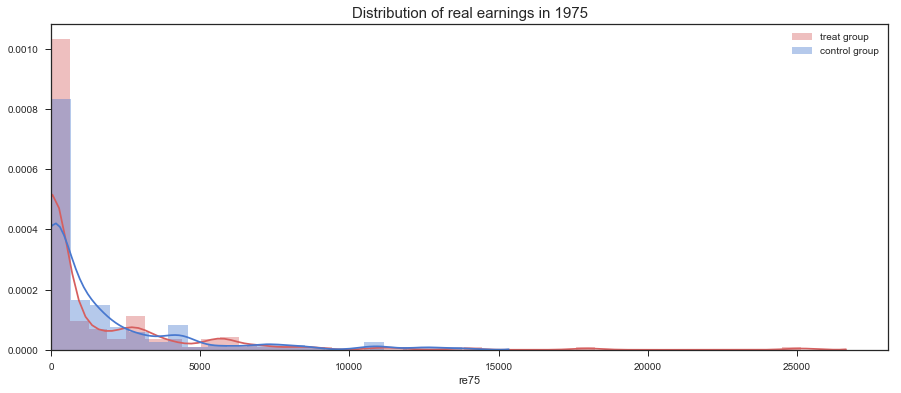

In [47]:
treat_group_value = df_treat['re75']
control_group_value = df_non_treat['re75']
title = 'Distribution of real earnings in 1975'
distribution_plot(treat_group_value, control_group_value, title)

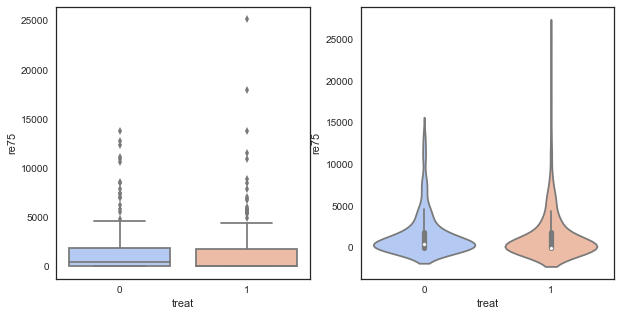

In [48]:
x_value = 'treat'
y_value = 're75'
data_value = df_matching
box_violin_plot(x_value, y_value, data_value)

After plotting the distribution, we observe that **most features (years of education, marital status, higher eduction status, earnings in 1974 & in 1975)** possess very similar distributions for the two groups. However, the distribtions of **age** and **race** are not truly satisfying. There exists a strong difference of these features for the two groups.
Thus, we can not draw a conclusion about this program at the moment. We are supposed to imporve our matching.

### 5. Balancing the groups further

Based on our comparison of feature-value distributions from part 4, we are not fully satisfied with the matching because there are still several features: **age & race** which have different feature-value distributions between treated and control group. Besides, the distributions of **nodegree** are not very similar as well but the difference is not very important.

There are two serious problematic features: **age & race**. However, We are only going to improve our matching by explicitly making sure that we match only subjects that have the same value for the feature **race** because it is meaning less to guarantee each pair has the same age value as long as the two values are in the same age range.

#### 5.1 - Method 1

We discard all the unsatisfied pairs from the matching dictionary and plot the new distributions with the update dictionary.

In [49]:
temp = dict_node.copy()
for x in dict_node.keys():
    if df_lalonde[df_lalonde['id'] == dict_node[x]]['black'].values[0] != df_lalonde[df_lalonde['id'] == x]['black'].values[0] or df_lalonde[df_lalonde['id'] == dict_node[x]]['hispan'].values[0] != df_lalonde[df_lalonde['id'] == x]['hispan'].values[0]:
        del temp[x]

In [50]:
df_new_matching = df_lalonde[df_lalonde['id'].isin(temp.keys())]
df_new_treat_matching =df_new_matching[df_new_matching["treat"] == 1]
df_new_non_treat_matching =df_new_matching[df_new_matching["treat"]==0]

#### 5.1.1 - Distributions of age

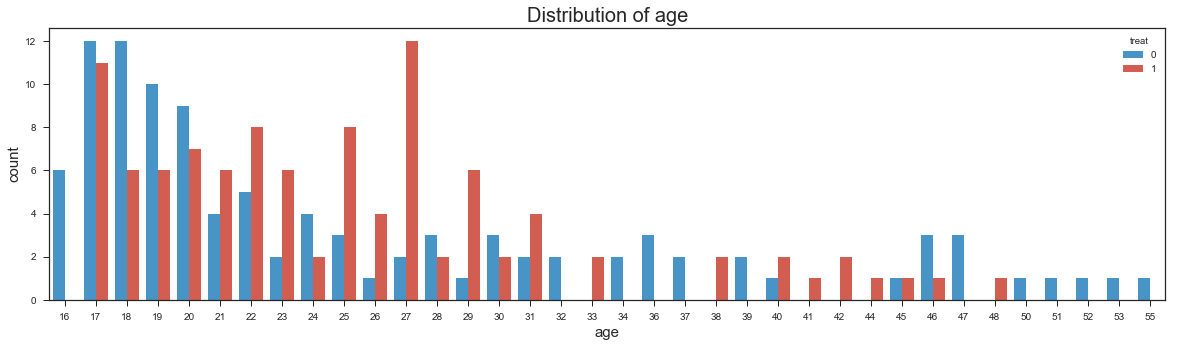

In [51]:
x_value = 'age'
hue_value = 'treat'
data_value = df_new_matching
title = 'Distribution of age'
histogram(x_value, hue_value, data_value, title)

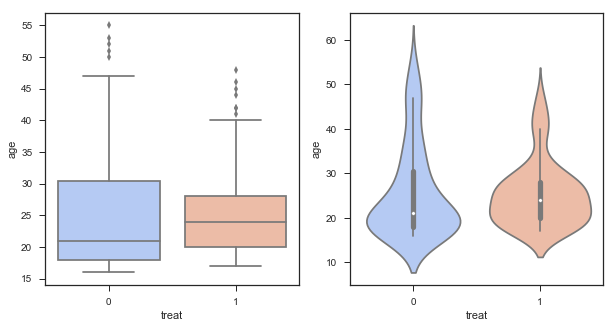

In [52]:
x_value = 'treat'
y_value = 'age'
data_value = df_new_matching
box_violin_plot(x_value, y_value, data_value)

#### 5.1.2 -  Distributions of years of education

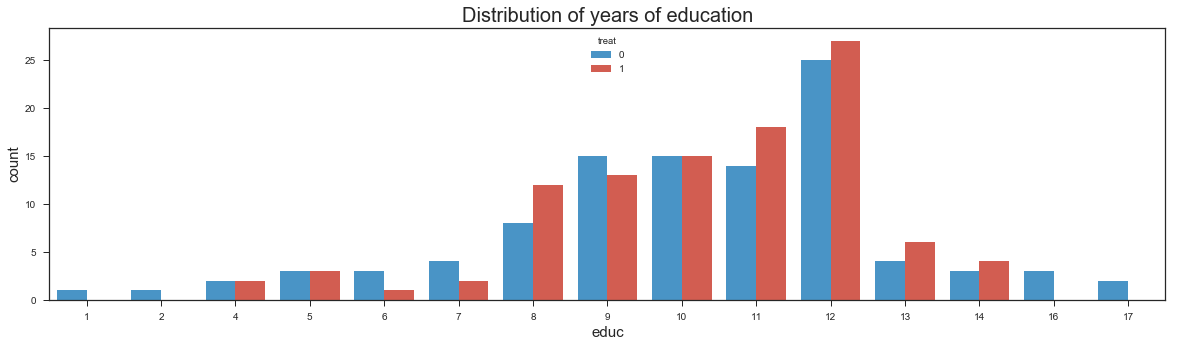

In [53]:
x_value = 'educ'
hue_value = 'treat'
data_value = df_new_matching
title = 'Distribution of years of education'
histogram(x_value, hue_value, data_value, title)

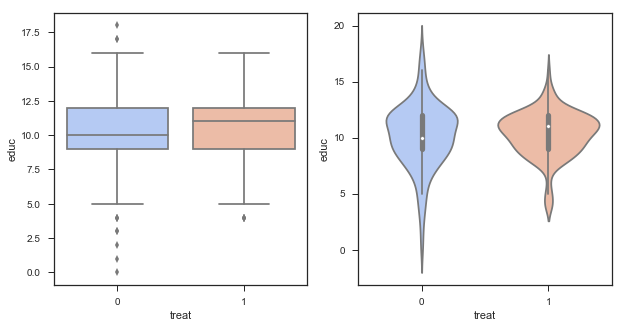

In [54]:
x_value = 'treat'
y_value = 'educ'
data_value = df_matching
box_violin_plot(x_value, y_value, data_value)

#### 5.1.3 - Distributions of race

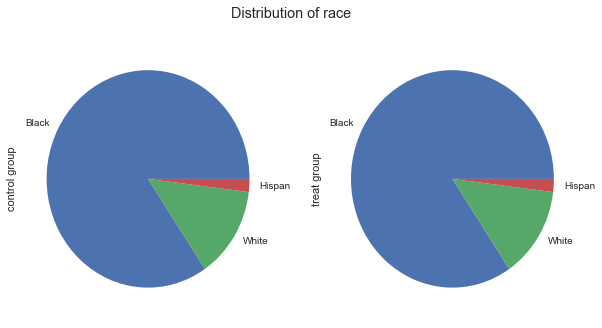

In [55]:
treat_race = (df_new_treat_matching.hispan + 2 * df_new_treat_matching.black).replace({0: 'White', 1: 'Hispan', 2: 'Black'}).value_counts()
control_race = (df_new_non_treat_matching.hispan + 2 * df_new_non_treat_matching.black).replace({0: 'White', 1: 'Hispan', 2: 'Black'}).value_counts()
pie_plot(treat_race, control_race, 'Distribution of race')

Evidently, the distributions of race is identical since we discard all the matches whose race values are different.

#### 5.1.4 - Distributions of marital status

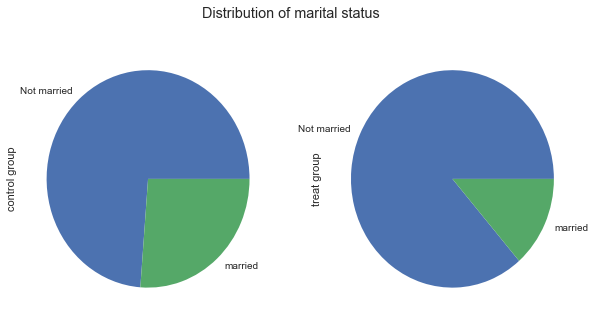

In [56]:
treat_marriage = df_new_treat_matching['married'].replace({0: 'Not married', 1: 'married'}).value_counts()
control_marriage = df_new_non_treat_matching['married'].replace({0: 'Not married', 1: 'married'}).value_counts()
pie_plot(treat_marriage, control_marriage, 'Distribution of marital status')

#### 5.1.5 - Distributions of higher education status

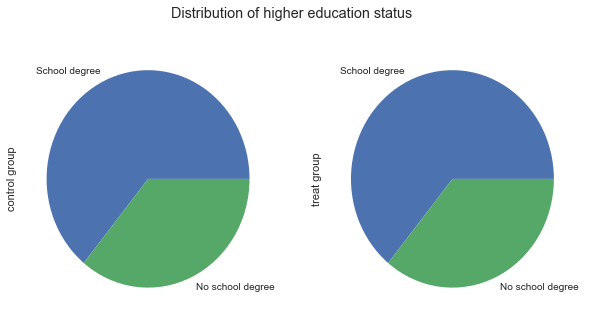

In [57]:
treat_educ = df_new_treat_matching['nodegree'].replace({0: 'No school degree', 1: 'School degree'}).value_counts()
control_educ = df_new_non_treat_matching['nodegree'].replace({0: 'No school degree', 1: 'School degree'}).value_counts()
pie_plot(treat_educ, control_educ, 'Distribution of higher education status')

#### 5.1.6 - Distributions of real earnings in 1974

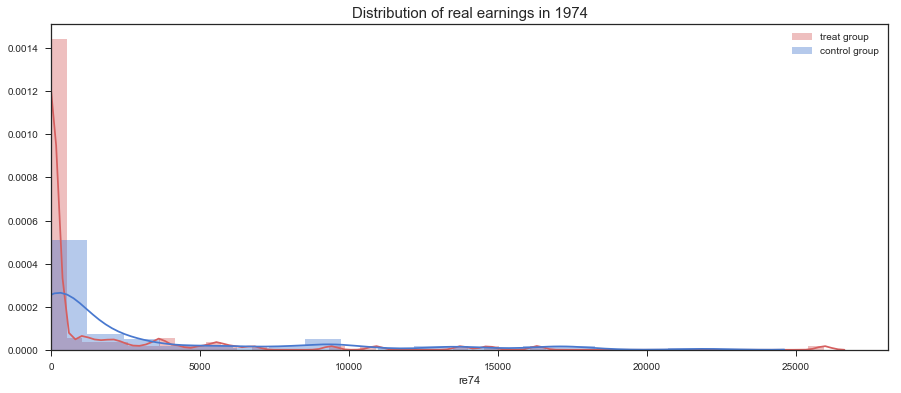

In [58]:
treat_group_value = df_new_treat_matching['re74']
control_group_value = df_new_non_treat_matching['re74']
title = 'Distribution of real earnings in 1974'
distribution_plot(treat_group_value, control_group_value, title)

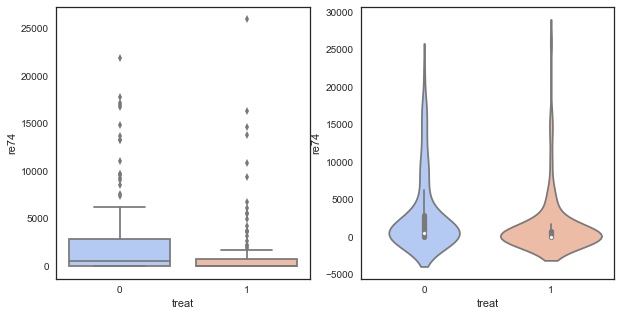

In [59]:
x_value = 'treat'
y_value = 're74'
data_value = df_new_matching
box_violin_plot(x_value, y_value, data_value)

#### 5.1.7 - Distributions of real earnings in 1975

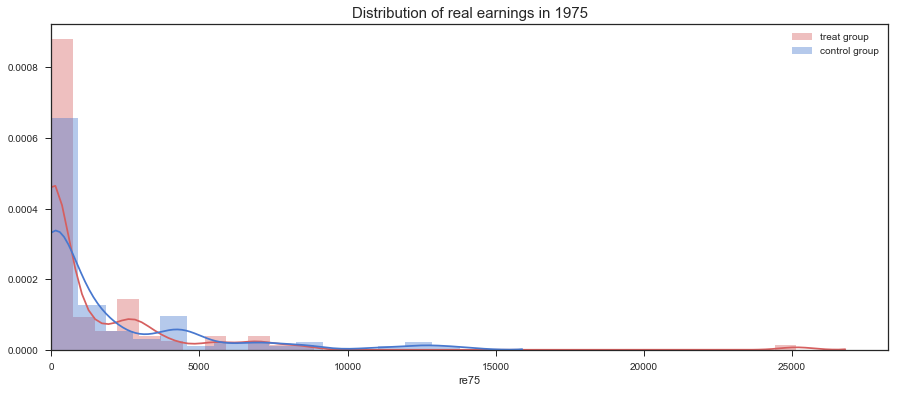

In [60]:
treat_group_value = df_new_treat_matching['re75']
control_group_value = df_new_non_treat_matching['re75']
title = 'Distribution of real earnings in 1975'
distribution_plot(treat_group_value, control_group_value, title)

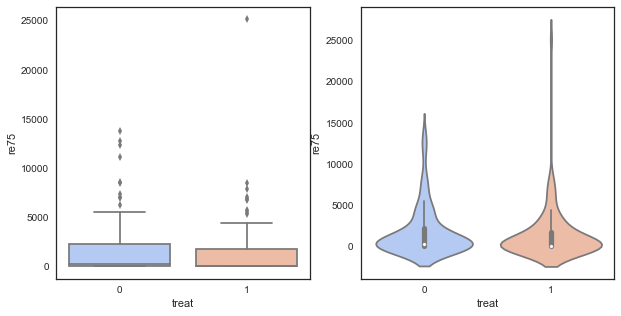

In [61]:
x_value = 'treat'
y_value = 're75'
data_value = df_new_matching
box_violin_plot(x_value, y_value, data_value)

After making sure that we match only subjects that have the same value for the problematic feature **race**, there are great improvements for the age and race distibutions as we can observe above. Unfortunately, the distribtion of **the marital status and earnings in 1974 & in 1975** become more or less **worse**. Thus, we can not say this is a very successful matching improvement.

#### 5.2 - Method 2
After finishing the above process, we are going to use a new method to balance the dataset because it is not very persuasive to use the new matching above to analyze the result as there remains only 100 pairs of subjects, the number of samples is too small.

In [62]:
print("There remains {} data after deleting all the unsatisfied matches.".format(df_new_matching.shape[0]))

There remains 206 data after deleting all the unsatisfied matches.


This time, we are going to delete all the unsatisfied control subjects from the original dataframe instead of the dataframe generated from the task 4. Then, we regenerated a new graph and match the new most similar 180 pairs and observe the new distribution.

Then, we decide to improve our matching by **nodegree** feature because after testing, we find it's impossible to obtain an improvement of feature distribution if we discard the unsatisfied subjects on basis of **race** or **age**.

We select all the control group subjects whose nodegree feature value is different from that of the corresponding treated group subject and then delete them.

In [63]:
del_list=[]
temp = dict_node.copy()
for x in dict_node.keys():
    if df_lalonde[df_lalonde['id'] == dict_node[x]]['nodegree'].values[0] != df_lalonde[df_lalonde['id'] == x]['nodegree'].values[0]:
        if x in df_non_treat_matching["id"].values:
            del_list.append(x)

In [64]:
df = df_lalonde.copy()
df.set_index("id",inplace=True)
df.drop(del_list,axis=0,inplace=True)
df.reset_index(inplace=True)

After discarding all the unsatified data from the original dataframe, we still have 572 subjects to match.

In [65]:
print("There remains {} data to match.".format(df.shape[0]))

There remains 531 data to match.


Now, we rematch the subjects with the same process as task 4.

In [66]:
T = nx.Graph()
T.add_nodes_from(df['id'].values)
for i in df[df['treat'] == 1]['id'].values:
    for j in df[df['treat'] == 0]['id'].values:
        w = - abs(df[df['id'] == i]['propensity score'].values[0] - df[df['id'] == j]['propensity score'].values[0])
        T.add_edge(i, j, weight=w)          
dict_node_new = nx.max_weight_matching(T,maxcardinality=True)

In [67]:
df_new_matching = df[df['id'].isin(dict_node_new.keys())]
df_new_treat_matching = df_new_matching[df_new_matching["treat"] == 1]
df_new_non_treat_matching = df_new_matching[df_new_matching["treat"] == 0]

#### 5.2.1 - Distributions of age

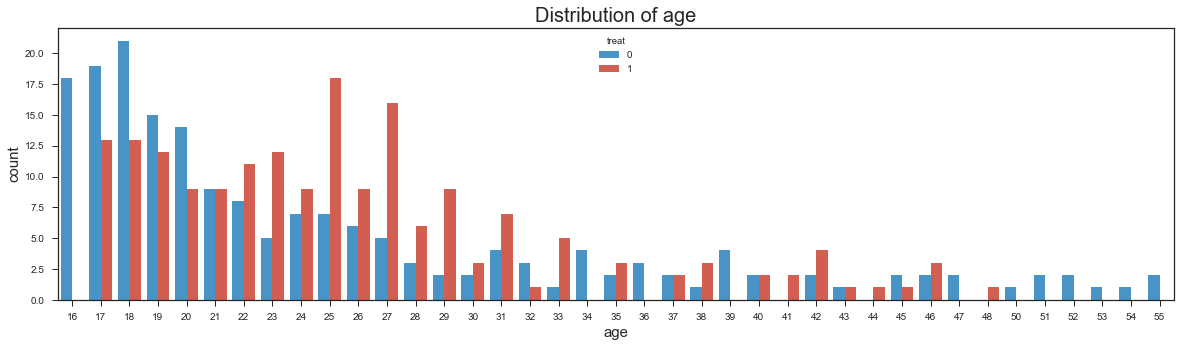

In [68]:
x_value = 'age'
hue_value = 'treat'
data_value = df_new_matching
title = 'Distribution of age'
histogram(x_value, hue_value, data_value, title)

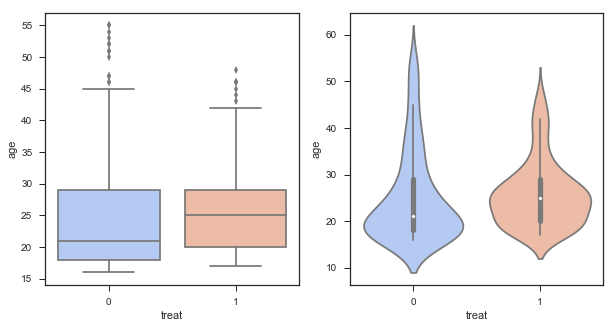

In [69]:
x_value = 'treat'
y_value = 'age'
data_value = df_new_matching
box_violin_plot(x_value, y_value, data_value)

#### 5.2.2 - Distributions of years of education

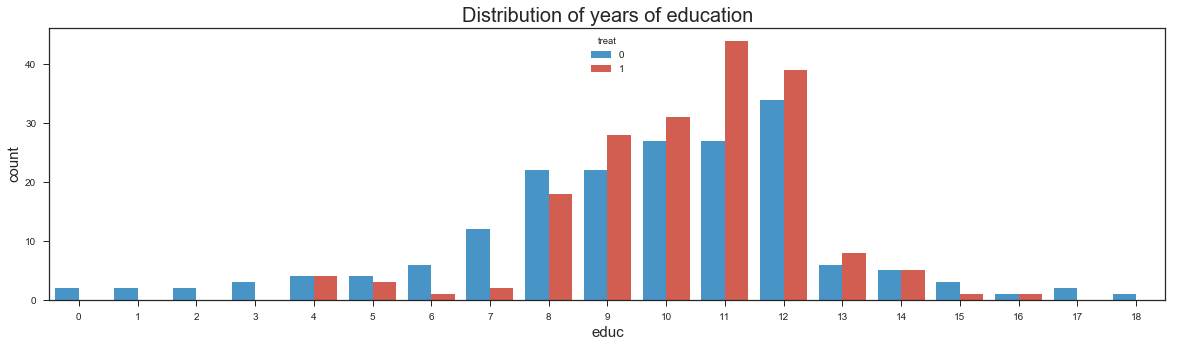

In [70]:
x_value = 'educ'
hue_value = 'treat'
data_value = df_new_matching
title = 'Distribution of years of education'
histogram(x_value, hue_value, data_value, title)

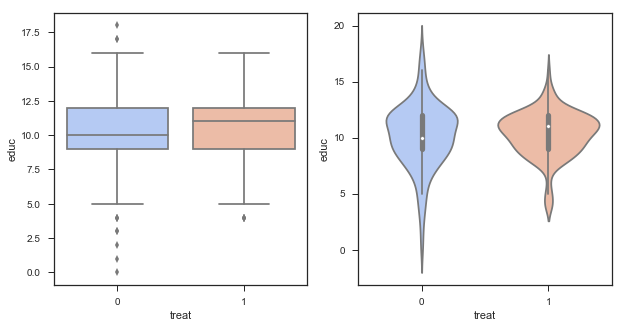

In [71]:
x_value = 'treat'
y_value = 'educ'
data_value = df_matching
box_violin_plot(x_value, y_value, data_value)

#### 5.2.3 - Distributions of race

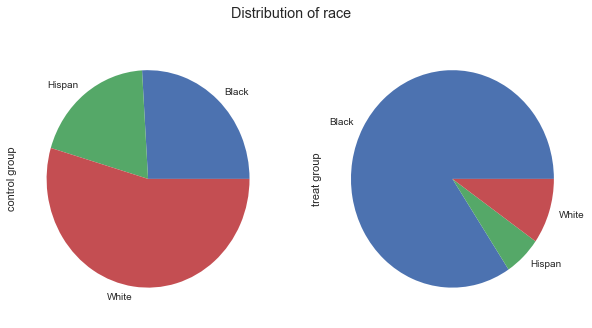

In [72]:
treat_race = (df_new_treat_matching.hispan + 2 * df_new_treat_matching.black).replace({0: 'White', 1: 'Hispan', 2: 'Black'}).value_counts()
control_race = (df_new_non_treat_matching.hispan + 2 * df_new_non_treat_matching.black).replace({0: 'White', 1: 'Hispan', 2: 'Black'}).value_counts()
pie_plot(treat_race, control_race, 'Distribution of race')

#### 5.2.4 - Distributions of marital status

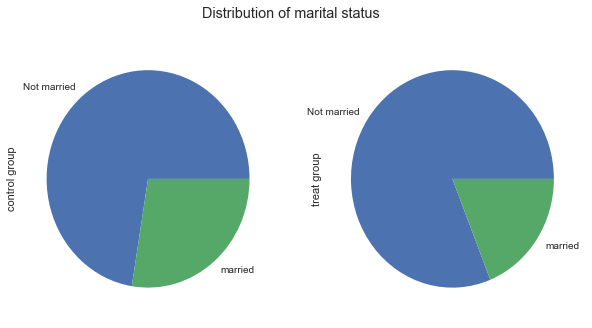

In [73]:
treat_marriage = df_new_treat_matching['married'].replace({0: 'Not married', 1: 'married'}).value_counts()
control_marriage = df_new_non_treat_matching['married'].replace({0: 'Not married', 1: 'married'}).value_counts()
pie_plot(treat_marriage, control_marriage, 'Distribution of marital status')

#### 5.2.5 - Distributions of no school degree

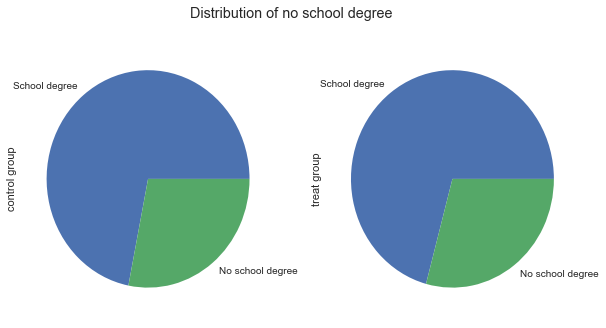

In [74]:
treat_educ = df_new_treat_matching['nodegree'].replace({0: 'No school degree', 1: 'School degree'}).value_counts()
control_educ = df_new_non_treat_matching['nodegree'].replace({0: 'No school degree', 1: 'School degree'}).value_counts()
pie_plot(treat_educ, control_educ, 'Distribution of no school degree')

#### 5.2.6 - Distributions of real earning in 1974

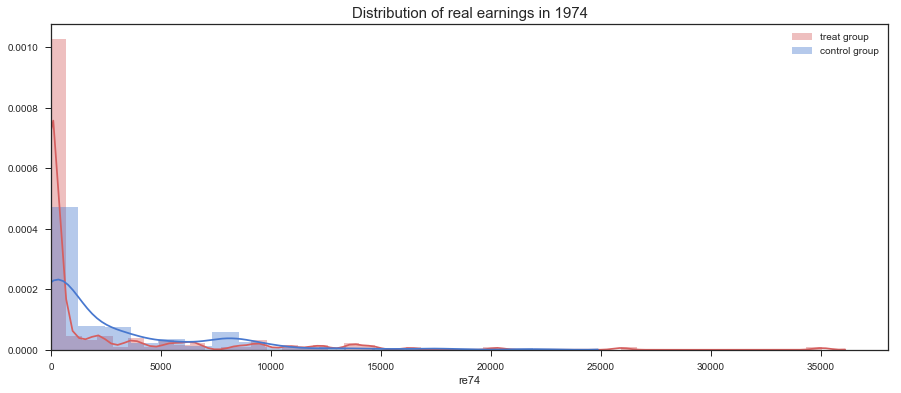

In [75]:
treat_group_value = df_new_treat_matching['re74']
control_group_value = df_new_non_treat_matching['re74']
title = 'Distribution of real earnings in 1974'
distribution_plot(treat_group_value, control_group_value, title)

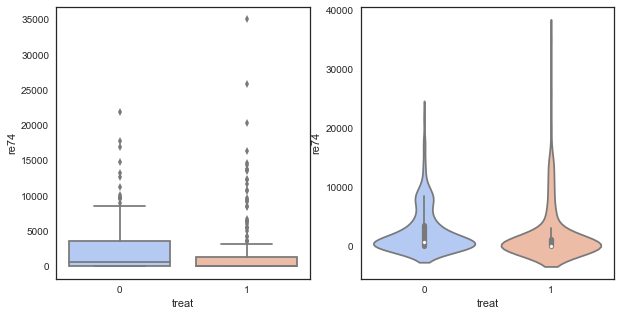

In [76]:
x_value = 'treat'
y_value = 're74'
data_value = df_new_matching
box_violin_plot(x_value, y_value, data_value)

#### 5.2.7 - Distributions of real earning in 1975

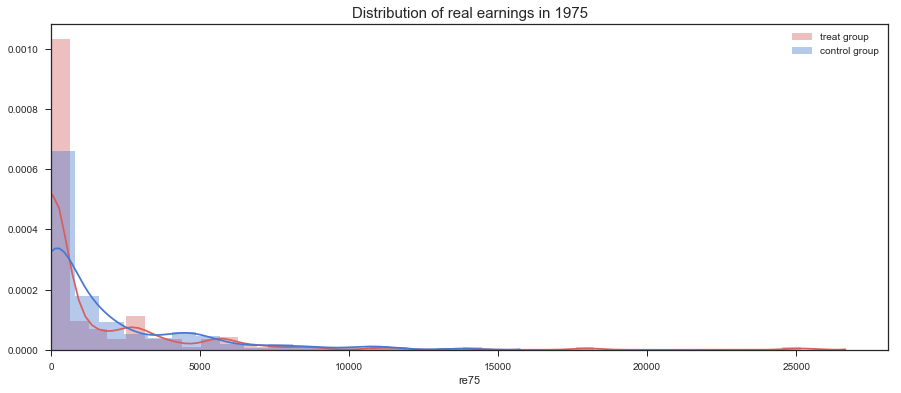

In [77]:
treat_group_value = df_new_treat_matching['re75']
control_group_value = df_new_non_treat_matching['re75']
title = 'Distribution of real earnings in 1975'
distribution_plot(treat_group_value, control_group_value, title)

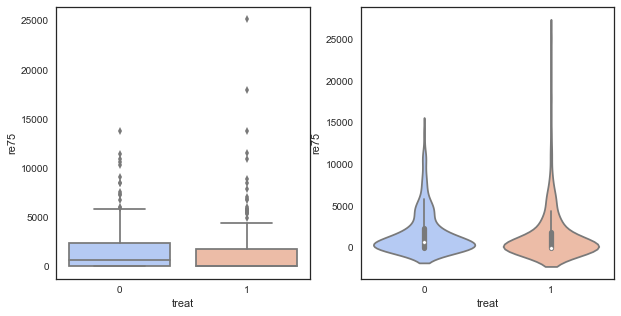

In [78]:
x_value = 'treat'
y_value = 're75'
data_value = df_new_matching
box_violin_plot(x_value, y_value, data_value)

On the basis of this new method, all the feature distributions become more similar except for the feature **race**. The race distribution is even worse than that of task 4. However, as most feature distributions have become more resemblant, we think the result of this new matching can be more persuasive than before. Hence, we decide to assume that **the feature race may not be an important factor** for the final income and to use the income in 1978 distribution of this new "balanced" dataset to analyze the effectiveness of the training program.

### 6. A less naive analysis - Conclusion about the effectiveness of the job training program

After task 3-5, we obtain a "balanced" dataset which allows us to draw valid and reasonable conclusions about this research. 

From our point of view, the first method of task 5 is not very persuasive due to the limit of sample amount. Thus, here in task 6, we are going to utilize the result of the second method to draw the conclusion.

Here is a brief description of the real earnings (outcome) in 1987 after the training program for the two groups:

In [79]:
treat_describe = df_new_treat_matching['re78'].describe()
control_describe = df_new_non_treat_matching['re78'].describe()
df_describe = pd.concat([treat_describe, control_describe], axis = 1)
df_describe.columns = ['treated group', 'control group']
df_describe

,treated group,control group
count,185.000000,185.000000
mean,6349.143530,5094.506320
std,7867.402218,5895.080369
min,0.000000,0.000000
25%,485.229800,0.000000
50%,4232.309000,2820.980000
75%,9642.999000,7675.312000
max,60307.930000,25564.670000


The **distribution plot, box plot and violin plot** below show us the distribution of the real earning in 1987 for the two groups.

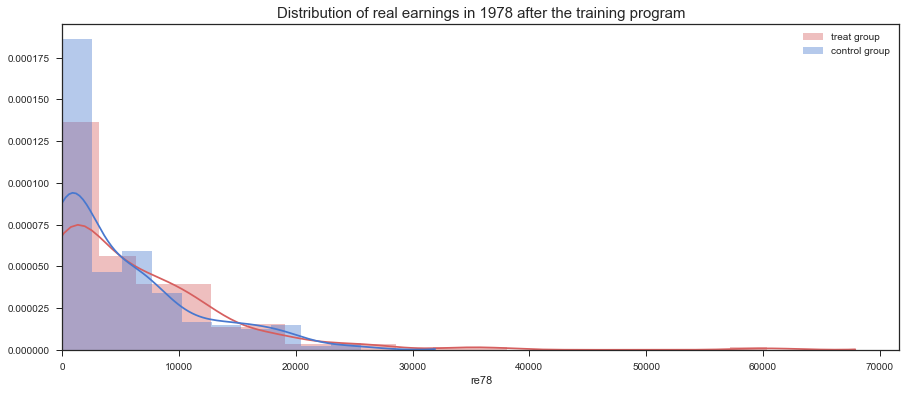

In [80]:
treat_group_value = df_new_treat_matching['re78']
control_group_value = df_new_non_treat_matching['re78']
title = 'Distribution of real earnings in 1978 after the training program'
distribution_plot(treat_group_value, control_group_value, title)

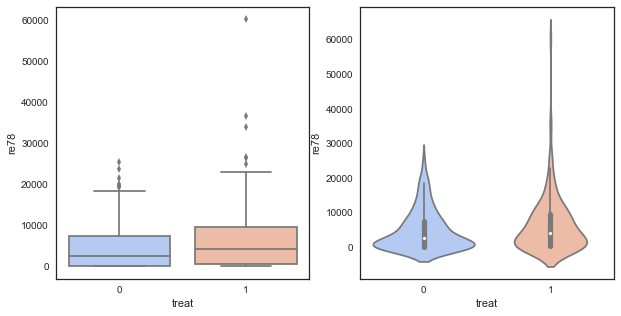

In [78]:
x_value = 'treat'
y_value = 're78'
data_value = df_new_matching
box_violin_plot(x_value, y_value, data_value)

#### Conclusion

Thanks to the data matching and processing accomplished in task 3-5, the distributions of earnings before the training program are quite similar between the two groups, which indicates that the final result of earnings after the program can truely represent the effectiveness of the program.

As we can observe, the mean, meadian and higher quartile values of those in the treated group are all impressively greater than those in the control group. Besides, there exists several trained people who own an excessively high salary which are presented by the outliers in the box plot. For example, the highest earnings among trained people is 60307.93 while the highest earnings among untrained people is only 23764.80, almost 3 times lower.

In all, we can conclude that the job training program is truly effective to help people improve their incomes.

## Question 2: Applied Machine Learning

### 1. From dataset to training set

#### Load the 20newsgroup dataset

In [33]:
from sklearn.datasets import fetch_20newsgroups

In [34]:
newsgroups_all = fetch_20newsgroups(data_home='./data/',subset='all')

In [62]:
newsgroups_all.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [35]:
newsgroups_all.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

#### Compute TF-IDF features for every article

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
newsgroups_vector = TfidfVectorizer().fit_transform(newsgroups_all.data)

#### Show the basics of our dataset

In [38]:
newsgroups_vector.shape

(18846, 173762)

In [39]:
newsgroups_all.target.shape

(18846,)

In [40]:
newsgroups_all.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

#### Split the dataset into training/testing/validation sets 

80% for training, 10% for validation and 10% for testing

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X = newsgroups_vector
y = newsgroups_all.target
# 80% is training set
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=2/10)
# 10% is testing set and 10% is validation set
X_test, X_valid, y_test, y_valid = train_test_split(X_testval, y_testval, test_size=1/2)

In [43]:
X_train.shape

(15076, 173762)

In [44]:
X_test.shape

(1885, 173762)

In [45]:
X_valid.shape

(1885, 173762)

### 2. Train a random forest

#### Create a [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) and see its default parameters.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
clf = RandomForestClassifier(n_jobs=-1)
clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Naive grid search for `n_estimators` and `max_depth`.

Ref. of range of values: An article from Kaggle Team [Approaching (Almost) Any Machine Learning Problem | Abhishek Thakur](http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/)

In [48]:
from sklearn.model_selection import ParameterGrid

In [49]:
params_grid = {'n_estimators': [120, 300, 500, 800], 
              'max_depth': [5, 15, 30, None]}

best_params = None
best_score = 0

for params in ParameterGrid(params_grid):
    clf.set_params(**params)
    clf.fit(X_train, y_train)
    score = clf.score(X_valid, y_valid)
    if score > best_score:
        best_params = params
        best_score = score

In [50]:
print('Best parameter choice is {}'.format(best_params))
print('Best score is {:.8f}'.format(best_score))

Best parameter choice is {'max_depth': None, 'n_estimators': 800}
Best score is 0.85358090


In [51]:
clf.set_params(**best_params)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

#### Display the confusion matrix 

Plot unnormalized the confusion matrix.

In [52]:
from sklearn.metrics import confusion_matrix

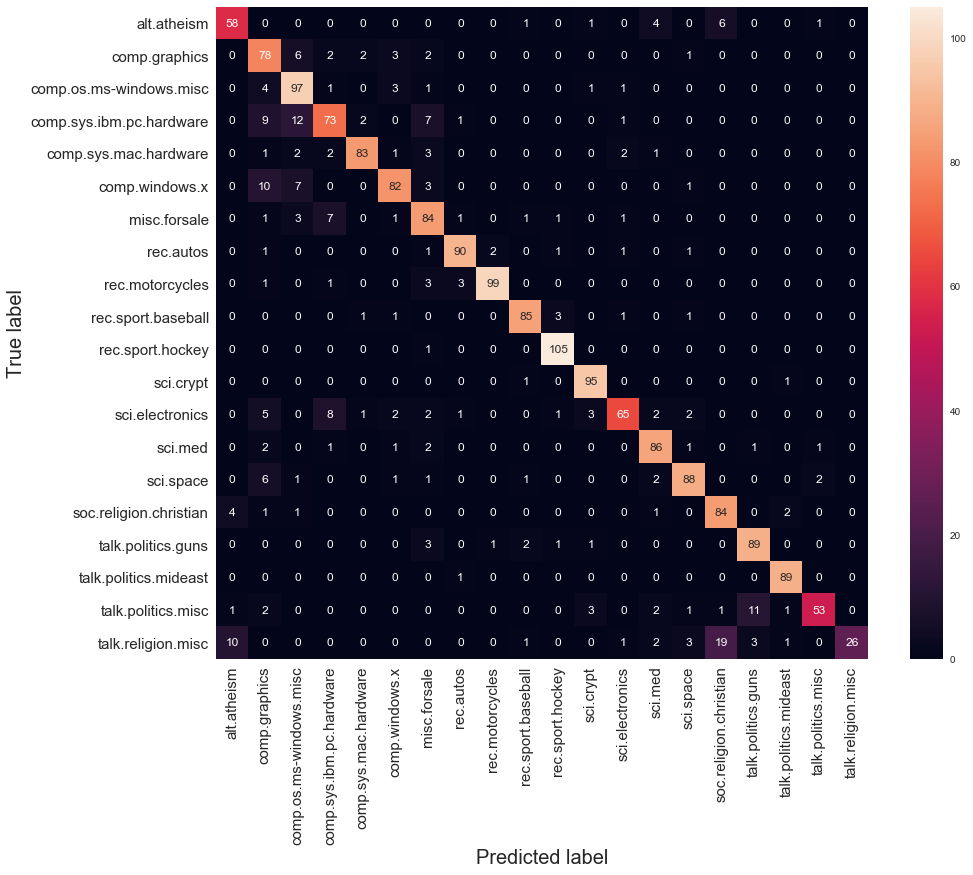

In [53]:
cm  = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(15,12))
ax = sns.heatmap(cm, square=True, annot=True, fmt='d',
                 yticklabels=newsgroups_all.target_names,
                 xticklabels=newsgroups_all.target_names)
plt.tick_params(axis='both', labelsize=15)
plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.show()

#### Discuss

In [54]:
fi = clf.feature_importances_

Have a look at the distribution of `feature_importance_`

In [55]:
pd.Series(fi).describe()

count    1.737620e+05
mean     5.754998e-06
std      5.522780e-05
min      0.000000e+00
25%      0.000000e+00
50%      1.309885e-07
75%      1.017516e-06
max      4.033015e-03
dtype: float64

Also, notice that `feature_importance_` is normalized.

In [56]:
fi.sum()

1.0

Most of the `feature_importance_` is very small, which makes it hard for visualization. 

So, we manually choose $10^{-4}$ as threshold, and only see the distribution of those large importance.

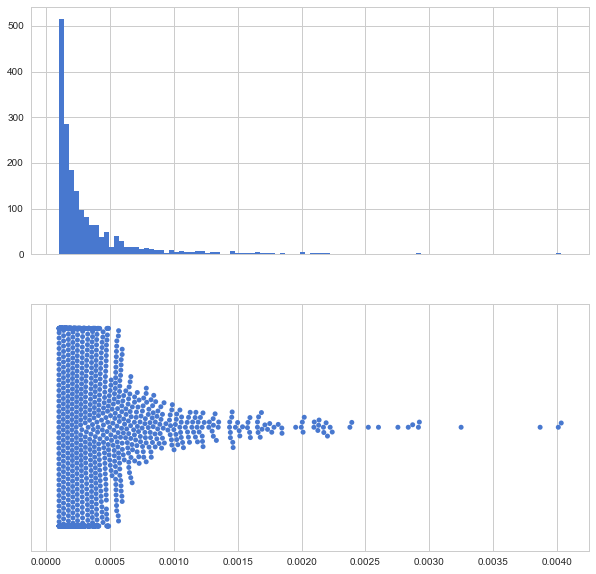

In [57]:
indx = np.where(fi<1*10**(-4))
non_zero_imp = np.delete(fi.copy(),indx)
sns.set(style="whitegrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10,10), sharex=True, sharey=False)
ax[0].hist(non_zero_imp,bins=100)
sns.swarmplot(x=non_zero_imp,ax=ax[1])
plt.show()

In [58]:
print("The number of importance bigger than 1e-4 is {}.".format(non_zero_imp.shape[0]))

The number of importance bigger than 1e-4 is 1828.


Now let's have a look at our data again. We calculate how sprase the vectors are by counting the nonzero entries for each vector.

There are only a few out of 18846 features that are non-zero for most of the observation, which indicates we use many very unimportant features here. 

In [59]:
pd.Series(np.asarray(np.sum(newsgroups_vector!=0, axis=1)).reshape(-1)).describe()

count    18846.000000
mean       156.666348
std        204.570470
min         15.000000
25%         83.000000
50%        121.000000
75%        177.000000
max      13671.000000
dtype: float64

**Conclusion:**

As we can see from the basic description of `feature_importance_` and from the visualization of the large part of it, most of the importance is relatively small and only a fewer big importance. There are 173762 feautures and only a few of them are greater than $10^{-4}$. We also have several features with very large importance here.

From the study above, we know that most of the features have relatively small impact on the classification and there are only part of those features contribute greatly. So, if we can somehow find these features before starting training or we can do some feature extraction, which transforms the data in the high-dimensional space to a space of fewer dimensions, we would speed up our algorithm since there are only a few features. 